In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML

# display wide notebook cells
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import functools

import util
import train_and_predict
import feature_importance
import feature_selection
from data import *

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# Read Data

In [5]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
path = Path('..\Data')

In [35]:
train_genomes_path = path / 'train_genomes.fasta'
train_genomes_metedata_path = path / 'train_genomes_info.csv'

test_genomes_path = path / 'test_genomes.fasta'
test_genomes_metedata_path = path / 'test_genomes_verified.csv'

train_dataset = GenomesData(train_genomes_path, train_genomes_metedata_path)
test_dataset = GenomesData(test_genomes_path, test_genomes_metedata_path)

Check split train dataset to train and validation according to insertion date

In [7]:
print('train dataset', len(train_dataset.data))

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)

train_idx, validation_idx = next(split.split())

X_train_raw, X_valid_raw = train_dataset.data[train_idx], train_dataset.data[validation_idx]
y_train, y_valid = train_dataset.y[train_idx], train_dataset.y[validation_idx]

print('train', len(X_train_raw), 'validation', len(X_valid_raw))

train dataset 641
train 513 validation 128


In [8]:
y_valid.value_counts()

1    89
0    39
Name: Label, dtype: int64

In [9]:
DATE_INSERTED = 'Date Inserted'

min_validation_date = min(train_dataset.metadata.iloc[validation_idx, :][DATE_INSERTED])
min_validation_date

Timestamp('2018-11-29 03:53:53.656000+0000', tz='UTC')

In [10]:
max_train_date = max(train_dataset.metadata.iloc[train_idx, :][DATE_INSERTED])
max_train_date

Timestamp('2018-11-29 03:08:47.637000+0000', tz='UTC')

In [11]:
assert min_validation_date > max_train_date

# Feature Selection - best k features according to chi2

## 15% validation

In [11]:
min_val = 50
max_val = 600
inc = 50

k_range = range(min_val, max_val + 1, inc)

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.15)
grid_search = feature_selection.perform_fs_k_best(train_dataset, k_range, split=split)
print(grid_search.best_params_)

param_name = 'k_best__k'
feature_selection.grid_search_results_to_df(grid_search, param_name)

Best roc_auc score is: 0.9118055555555555
{'k_best__k': 600}


mean_test_balanced_accuracy  mean_test_roc_auc
param_k_best__k                                                
50                                     0.775              0.865
100                                    0.811              0.863
150                                    0.819              0.897
200                                    0.811              0.896
250                                    0.806              0.894
300                                    0.819              0.895
350                                    0.811              0.898
400                                    0.811              0.899
450                                    0.811              0.901
500                                    0.833              0.903
550                                    0.828              0.903
600                                    0.842              0.912

## 20% validation

In [12]:
min_val = 50
max_val = 600
inc = 50

k_range = range(min_val, max_val + 1, inc)

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)
grid_search = feature_selection.perform_fs_k_best(train_dataset, k_range, split=split)
print(grid_search.best_params_)

param_name = 'k_best__k'
feature_selection.grid_search_results_to_df(grid_search, param_name)

Best roc_auc score is: 0.9030538749639873
{'k_best__k': 450}


mean_test_balanced_accuracy  mean_test_roc_auc
param_k_best__k                                                
50                                     0.832              0.873
100                                    0.828              0.885
150                                    0.813              0.882
200                                    0.815              0.897
250                                    0.826              0.896
300                                    0.837              0.896
350                                    0.837              0.898
400                                    0.832              0.899
450                                    0.844              0.903
500                                    0.824              0.898
550                                    0.826              0.897
600                                    0.850              0.901

## 5-fold stratified cross validation

In [13]:
min_val = 50
max_val = 600
inc = 50

k_range = range(min_val, max_val + 1, inc)

kf = StratifiedKFold(n_splits=5)
grid_search = feature_selection.perform_fs_k_best(train_dataset, k_range, split=kf)
print(grid_search.best_params_)

param_name = 'k_best__k'
feature_selection.grid_search_results_to_df(grid_search, param_name)

Best roc_auc score is: 0.9627397654572917
{'k_best__k': 550}


mean_test_balanced_accuracy  mean_test_roc_auc
param_k_best__k                                                
50                                     0.884              0.934
100                                    0.889              0.951
150                                    0.894              0.955
200                                    0.900              0.958
250                                    0.904              0.955
300                                    0.897              0.956
350                                    0.892              0.958
400                                    0.899              0.957
450                                    0.897              0.961
500                                    0.897              0.962
550                                    0.896              0.963
600                                    0.891              0.961

The 5-fold cross validation didn't give consistent results. In my opinion 20% validation set is prefered.

# Feature Selection - select best feature from each cluster

In [14]:
min_val = 0
max_val = 0.6
inc = 0.03
t_range = np.arange(min_val, max_val, inc)

# created corr matrix using feature_selection.create_corr_matrix(X_train_raw, y_train) 
corr_matrix_path = path / 'X_train_corr_mat_0.8_k450.csv'
corr_matrix_train = pd.read_csv(corr_matrix_path, index_col=0)
dist_matrix_train = feature_selection.feature_corr_to_dist_matrix(corr_matrix_train)

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)
grid_search_cluster = feature_selection.perform_fs_clusters(train_dataset, dist_matrix_train, t_range, split=split)
print(grid_search_cluster.best_params_)

param_name = 'cluster__threshold'
feature_selection.grid_search_results_to_df(grid_search_cluster, param_name)

threshold=0.0, selected_features= 450
threshold=0.03, selected_features= 406
threshold=0.06, selected_features= 373
threshold=0.09, selected_features= 329
threshold=0.12, selected_features= 298
threshold=0.15, selected_features= 270
threshold=0.18, selected_features= 244
threshold=0.21, selected_features= 219
threshold=0.24, selected_features= 201
threshold=0.27, selected_features= 181
threshold=0.3, selected_features= 159
threshold=0.32999999999999996, selected_features= 136
threshold=0.36, selected_features= 116
threshold=0.39, selected_features= 95
threshold=0.42, selected_features= 74
threshold=0.44999999999999996, selected_features= 60
threshold=0.48, selected_features= 47
threshold=0.51, selected_features= 37
threshold=0.54, selected_features= 30
threshold=0.57, selected_features= 18
threshold=0.0, selected_features= 450
Best roc_auc score is: 0.9030538749639873
{'cluster__threshold': 0.0}


mean_test_balanced_accuracy  mean_test_roc_auc
param_cluster__threshold                                                
0.00                                            0.844              0.903
0.03                                            0.850              0.899
0.06                                            0.843              0.898
0.09                                            0.824              0.898
0.12                                            0.843              0.901
0.15                                            0.850              0.901
0.18                                            0.850              0.903
0.21                                            0.856              0.898
0.24                                            0.850              0.900
0.27                                            0.856              0.901
0.30                                            0.856              0.893
0.33                                            0.850              0.892
0.36                                            0.850              0.892
0.39                                            0.856              0.897
0.42                                            0.839              0.897
0.45                                            0.844              0.900
0.48                                            0.844              0.896
0.51                                            0.832              0.876
0.54                                            0.819              0.877
0.57                                            0.824              0.875

# Final model

## Perform feature selection process on the entire train dataset, using best parameters

In [12]:
best_k = 450
best_t = 0.18

In [13]:
X_train_raw, X_test_raw = train_dataset.data, test_dataset.data
y_train, y_test = train_dataset.y, test_dataset.y

# created corr matrix using feature_selection.create_corr_matrix(X_train_raw, y_train) 
corr_matrix_path = path / 'X_train_corr_mat_k450.csv'
X_train_corr_matrix = pd.read_csv(corr_matrix_path, index_col=0)
X_train_dist_mat = feature_selection.feature_corr_to_dist_matrix(X_train_corr_matrix)

fs_pipeline = Pipeline(steps=[('vectorize', CountVectorizer(lowercase=False, binary=True)),
                               ('k_best', SelectKBest(score_func=sklearn.feature_selection.chi2, k=best_k)),
                               ('cluster', feature_selection.SelectHierarchicalClustering(X_train_dist_mat, threshold=best_t)),
                               ('rf', RandomForestClassifier(random_state=0))])

fs_pipeline.fit(X_train_raw, y_train)

results = train_and_predict.predict_and_print_results(X_test_raw, y_test, fs_pipeline)

threshold=0.18, selected_features= 250
false_positive: 21,total NHPs: 102
false_negative: 6,total HPs: 102
BAcc: 0.87
sensitivity: 0.94
specificity: 0.79
aupr_auc: 0.96
roc_auc: 0.95


In [14]:
y_train.value_counts()

1    428
0    213
Name: Label, dtype: int64

## Extract final features

In [20]:
all_pgfams = pd.array(fs_pipeline['vectorize'].get_feature_names())
k_best_pgfams = all_pgfams[fs_pipeline['k_best'].get_support()]
cluster_pgfams = k_best_pgfams[fs_pipeline['cluster'].get_support()]

In [21]:
vectorizer = CountVectorizer(lowercase=False, binary=True, vocabulary=cluster_pgfams)
vectorizer.fit_transform(X_train_raw)

<641x250 sparse matrix of type '<class 'numpy.int64'>'
	with 41335 stored elements in Compressed Sparse Row format>

In [22]:
assert all(cluster_pgfams == vectorizer.get_feature_names())

## Final WSPC model
A random forest model, which includes the selected genes as features

In [23]:
WSPC, results = train_and_predict.train_and_predict(X_train_raw, y_train, X_test_raw, y_test, features=cluster_pgfams)

false_positive: 21,total NHPs: 102
false_negative: 6,total HPs: 102
BAcc: 0.87
sensitivity: 0.94
specificity: 0.79
aupr_auc: 0.96
roc_auc: 0.95


# Test according to groups

In [19]:
GROUP = 'Group'
GENOME_ID = 'Genome ID'

In [24]:
test_dataset.metadata.head()

Genome Name Label HP/NHP  \
Genome ID                                                          
163603.4    Actinomadura latina strain ATCC BAA-277    HP    1/0   
648.157            Aeromonas caviae strain ScAc2001    HP    9/0   
565.15          Atlantibacter hermannii strain 3608    HP    1/0   
2026190.21         Bacillus mobilis strain 1428.155    HP    1/0   
29459.655     Brucella melitensis strain HN20190002    HP   13/0   

                            species                     References Group  \
Genome ID                                                                  
163603.4        Actinomadura latina  \cite{trujillo1997polyphasic}    HP   
648.157            Aeromonas caviae              \cite{tang2020co}    HP   
565.15      Atlantibacter hermannii  \cite{ioannou2019escherichia}    HP   
2026190.21         Bacillus mobilis              \cite{2026190.21}    HP   
29459.655       Brucella melitensis         \cite{li2020molecular}    HP   

                      Host Name Isolation Source Isolation Comments  \
Genome ID                                                             
163603.4    Human, Homo sapiens   arm of patient                NaN   
648.157     Human, Homo sapiens  Watery diarrhea                NaN   
565.15      Human, Homo sapiens       Wound swab                NaN   
2026190.21  Human, Homo sapiens            wound                NaN   
29459.655   Human, Homo sapiens              NaN                NaN   

           Genome Quality Collection Date                    Date Inserted  \
Genome ID                                                                    
163603.4             Good             NaN 2020-04-26 17:38:00.943000+00:00   
648.157              Good         2019-05 2020-01-31 23:41:12.327000+00:00   
565.15               Good            2015 2020-02-07 13:50:54.571000+00:00   
2026190.21           Good      2016-01-01 2020-03-27 13:50:46.286000+00:00   
29459.655            Good      2019-02-04 2020-01-31 21:07:14.657000+00:00   

           Other Clinical              Host Health Disease  \
Genome ID                                                    
163603.4              NaN                      NaN     NaN   
648.157               NaN                 Diarrhea     NaN   
565.15                NaN        Wound infection 8     NaN   
2026190.21            NaN  chronic wound infection     NaN   
29459.655             NaN                      NaN     NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [36]:
test_dataset.metadata[GROUP].value_counts()

OHP     76
NHP     61
ONHP    41
HP      26
Name: Group, dtype: int64

In [37]:
y_pred = WSPC.predict_proba(test_dataset.data)[:, 1].round(2)

In [38]:
test_genomes_with_pred = test_dataset.metadata.copy()
test_genomes_with_pred['Pred'] = y_pred
test_genomes_with_pred

Genome Name  \
Genome ID                                                                               
163603.4                                      Actinomadura latina strain ATCC BAA-277   
648.157                                              Aeromonas caviae strain ScAc2001   
565.15                                            Atlantibacter hermannii strain 3608   
2026190.21                                           Bacillus mobilis strain 1428.155   
29459.655                                       Brucella melitensis strain HN20190002   
87883.284                                       Burkholderia multivorans strain C1576   
195.2778                                             Campylobacter coli strain 202823   
201.69                                               Campylobacter lari strain 503734   
2572066.4                                               Campylobacter sp. CFSAN093243   
1491.1756                                Clostridium botulinum strain ZBS3\_16-240-01   
65058.433                                       Corynebacterium ulcerans strain 02-13   
208962.153                                          Escherichia albertii strain 13S38   
562.55247                                                Escherichia coli strain 4374   
210.6620                                             Helicobacter pylori strain MHP47   
104628.50                                         Helicobacter suis strain NHP19-4022   
44275.61                  Leptospira interrogans serovar Copenhageni strain CLEP00179   
1639.7756                                 Listeria monocytogenes strain SCPM-O-B-7909   
78331.108                                  Mycobacterium canettii strain NLA000701671   
1768.199                                   Mycobacterium kansasii strain JALMAMYKAN-1   
2664891.3                               Mycobacterium tuberculosis complex sp. AY1MRC   
1773.20690         Mycobacterium tuberculosis strain Mycobacterium tuberculosis 79499   
485.8128                      Neisseria gonorrhoeae strain 5671 strain not applicable   
90370.3046    Salmonella enterica subsp. enterica serovar Typhi strain 343077\_206161   
624.2242                                               Shigella sonnei strain 7109.28   
686.65                               Vibrio cholerae O1 biovar El Tor strain NALMLE37   
150053.31                      Yersinia enterocolitica subsp. palearctica strain Ye9N   
85698.208                                    Achromobacter xylosoxidans strain DN2019   
470.9648                                  Acinetobacter baumannii strain KT\_2016\_39   
29430.96                                      Acinetobacter haemolyticus strain 11654   
28090.110            Acinetobacter lwoffii strain FDAARGOS\_620 strain Not applicable   
48296.376                                        Acinetobacter pittii strain VNMU 150   
2026186.33                                  Bacillus paranthracis strain ELWA-3\_3298   
817.1653                                            Bacteroides fragilis strain PP971   
95486.460                                     Burkholderia cenocepacia strain MS-2140   
292.237                                            Burkholderia cepacia strain IST612   
28450.2018                                   Burkholderia pseudomallei strain haikou8   
1507806.57                          Campylobacter fetus subsp. testudinum strain wqj4   
57706.80                                           Citrobacter braakii strain CB00017   
67824.24                                          Citrobacter farmeri strain YDC697-2   
546.797                                          Citrobacter freundii strain YDC638-3   
545.121                                            Citrobacter koseri strain AS012499   
67827.42                                        Citrobacter werkmanii strain YDC667-1   
133448.15                                         Citrobacter youngae strain AS012330   
1496.5104                                     Clostridioides difficil

In [39]:
test_genomes_with_pred[test_genomes_with_pred['Pred'].between(0.4,0.6)]

Genome Name  \
Genome ID                                                                      
1353.134                               Enterococcus gallinarum strain EGR748   
109328.8                             Leptotrichia trevisanii strain JMUB3870   
44250.11                                 Paenibacillus alvei strain bk032014   
1343.51                           Streptococcus vestibularis strain AS012761   
40545.1254                             Sutterella wadsworthensis strain 809h   
1423.1028                                       Bacillus subtilis strain 8-1   
2044595.31     Candidatus Gracilibacteria bacterium strain P-C-F\_MAG\_00005   
2026720.132   Candidatus Saccharibacteria bacterium strain T-D-F\_MAG\_00008   
35703.89                            Citrobacter amalonaticus strain BIOML-A5   
1898207.3769                Clostridiales bacterium strain T-D-F\_MAG\_00006   
218538.1051                                   Dialister invisus strain P2A-1   
1352.8997                                    Enterococcus faecium strain C59   
2584653.3                                            Finegoldia sp. BIOML-A5   
1871037.250             Flavobacteriaceae bacterium strain P-A-M\_MAG\_00002   
2049035.5                         Mogibacterium sp. strain T-C-M\_MAG\_00002   
1505.72                           Paeniclostridium sordellii strain BIOML-A6   
2044938.12         candidate division SR1 bacterium strain P-B-M\_MAG\_00018   

             Label HP/NHP                                  species  \
Genome ID                                                            
1353.134        HP    2/1                  Enterococcus gallinarum   
109328.8        HP    1/0                  Leptotrichia trevisanii   
44250.11        HP    1/0                      Paenibacillus alvei   
1343.51         HP    1/1               Streptococcus vestibularis   
40545.1254      HP   20/0                Sutterella wadsworthensis   
1423.1028      NHP    0/3                        Bacillus subtilis   
2044595.31     NHP    0/2  unclassified Candidatus Gracilibacteria   
2026720.132    NHP   0/20            unclassified Saccharibacteria   
35703.89       NHP   1/13                 Citrobacter amalonaticus   
1898207.3769   NHP    0/9               unclassified Clostridiales   
218538.1051    NHP    0/1                        Dialister invisus   
1352.8997      NHP  666/7                     Enterococcus faecium   
2584653.3      NHP    0/5                  unclassified Finegoldia   
1871037.250    NHP    1/3           unclassified Flavobacteriaceae   
2049035.5      NHP    0/3               unclassified Mogibacterium   
1505.72        NHP    4/2               Paeniclostridium sordellii   
2044938.12     NHP   0/19                    unclassified Bacteria   

                                                 References Group  \
Genome ID                                                           
1353.134             \cite{monticelli2018clinical,1353.134}   OHP   
109328.8                       \cite{eribe2017leptotrichia}   OHP   
44250.11                            \cite{padhi2013urinary}   OHP   
1343.51            \cite{tufan2010spondylodiscitis,1343.51}   OHP   
40545.1254              \cite{wang2013increased,40545.1254}   OHP   
1423.1028          \cite{elshaghabee2017bacillus,1423.1028}   NHP   
2044595.31                     \cite{nibali2020differences}  ONHP   
2026720.132                           \cite{perez2014newly}  ONHP   
35703.89      \cite{poyet2019library,garcia2016citrobacter}  ONHP   
1898207.3769                          \cite{perez2014newly}  ONHP   
218538.1051                   \cite{morio2007antimicrobial}  ONHP   
1352.8997                       \cite{zhou2020enterococcus}  ONHP   
2584653.3         \cite{poyet2019library,bruggemann2018pan}  ONHP   
1871037.250                       \cite{cao2018comparative}  ONHP   
2049035.5                             \cite{perez2014newly}  ONHP   
1505.72              \cite{poyet2019libr

In [41]:
test_nhp = test_genomes_with_pred[test_genomes_with_pred[LABEL]==NHP]
test_nhp[test_nhp['Pred']>=0.9]

Genome Name Label HP/NHP  \
Genome ID                                                          
2681551.3                 Staphylococcus sp. 170179   NHP    3/2   
1396.2563                Bacillus cereus strain 2-1   NHP   16/7   
158836.472  Enterobacter hormaechei strain BIOML-A4   NHP  305/6   
1282.3805      Staphylococcus epidermidis strain JH   NHP  85/69   
1311.2752      Streptococcus agalactiae strain M134   NHP  236/5   

                                species  \
Genome ID                                 
2681551.3   unclassified Staphylococcus   
1396.2563               Bacillus cereus   
158836.472      Enterobacter hormaechei   
1282.3805    Staphylococcus epidermidis   
1311.2752      Streptococcus agalactiae   

                                                 References Group  \
Genome ID                                                           
2681551.3                     \cite{pain2020staphylococcus}   NHP   
1396.2563                 \cite{zhu2016probiotic,1396.2563}  ONHP   
158836.472  \cite{poyet2019library,paauw2009identification}  ONHP   
1282.3805           \cite{otto2009staphylococcus,1282.3805}  ONHP   
1311.2752                             \cite{raabe2019group}  ONHP   

                      Host Name                Isolation Source  \
Genome ID                                                         
2681551.3   Human, Homo sapiens                            skin   
1396.2563   Human, Homo sapiens                             NaN   
158836.472  Human, Homo sapiens  fecal material [ENVO:00002003]   
1282.3805   Human, Homo sapiens                    Healthy skin   
1311.2752   Human, Homo sapiens                          cervix   

           Isolation Comments Genome Quality Collection Date  \
Genome ID                                                      
2681551.3                 NaN           Good        Feb-2019   
1396.2563                 NaN           Good        Apr-2016   
158836.472                NaN           Good     07-Jan-2015   
1282.3805                 NaN           Good     10-Dec-2018   
1311.2752                 NaN           Good            2017   

                              Date Inserted Other Clinical Host Health  \
Genome ID                                                                
2681551.3  2019-12-31 18:50:28.788000+00:00            NaN         NaN   
1396.2563  2020-02-02 13:49:51.345000+00:00            NaN         NaN   
158836.472 2020-02-01 13:47:59.584000+00:00            NaN         NaN   
1282.3805  2020-04-12 07:06:05.496000+00:00            NaN         NaN   
1311.2752  2020-01-31 04:58:24.727000+00:00            NaN     healthy   

           Disease  \
Genome ID            
2681551.3      NaN   
1396.2563      NaN   
158836.472     NaN   
1282.3805      NaN   
1311.2752      NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Comments  \
Genome ID                                                                                                                                                                                                                                                                                                                                                                                        

In [42]:
test_hp = test_genomes_with_pred[test_genomes_with_pred[LABEL]==HP]
test_hp[test_hp['Pred']<=0.1]

Genome Name Label  HP/NHP  \
Genome ID                                                         
817.1653        Bacteroides fragilis strain PP971    HP   61/45   
487.3238   Neisseria meningitidis strain N186\_00    HP  278/43   

                          species                     References Group  \
Genome ID                                                                
817.1653     Bacteroides fragilis   \cite{wexler2007bacteroides}   OHP   
487.3238   Neisseria meningitidis  \cite{bernardini2004proteome}   OHP   

                     Host Name     Isolation Source Isolation Comments  \
Genome ID                                                                
817.1653   Human, Homo sapiens                  Pus                NaN   
487.3238   Human, Homo sapiens  cerebrospinal fluid                NaN   

          Genome Quality Collection Date                    Date Inserted  \
Genome ID                                                                   
817.1653            Good            2019 2020-07-01 12:00:40.813000+00:00   
487.3238            Good            2000 2020-01-31 04:28:44.579000+00:00   

          Other Clinical              Host Health Disease  \
Genome ID                                                   
817.1653             NaN  Intersphinteric abscess     NaN   
487.3238             NaN    Meningococcal disease     NaN   

                                                                                                                                      Comments  \
Genome ID                                                                                                                                        
817.1653                                                                     Bacteroides fragilis whole genome sequenced from clinical samples   
487.3238   Whole genome analisis of Neisseria meningitidis serogroup C of ET-103 comples isolated in Sao Paulo, Brazil in the last two decades   

           Pred  
Genome ID        
817.1653   0.08  
487.3238   0.00

In [43]:
for group_name, genomes in test_dataset.metadata.groupby(GROUP):
    
    X_test_group = X_test_raw[genomes.index]
    y_test_group = y_test[genomes.index]
    
    y_pred = WSPC.predict(X_test_group)
    correct = sklearn.metrics.accuracy_score(y_test_group, y_pred, normalize=False)
    accuracy = sklearn.metrics.accuracy_score(y_test_group, y_pred)
    
    y_probs = WSPC.predict_proba(X_test_group)[:, 1]
    average_score = np.average(y_probs)
    print(f'{group_name}\taccuracy={accuracy:.2f} correctly predicted={correct}/{len(y_test_group)} average score={average_score:.2f}')


HP	accuracy=1.00 correctly predicted=26/26 average score=0.94
NHP	accuracy=0.93 correctly predicted=57/61 average score=0.13
OHP	accuracy=0.92 correctly predicted=70/76 average score=0.90
ONHP	accuracy=0.59 correctly predicted=24/41 average score=0.43


In [44]:
hp_opp_indexes = test_dataset.metadata[test_dataset.metadata[GROUP] == 'OHP'].index
hp_indexes = test_dataset.metadata[test_dataset.metadata[GROUP] == 'HP'].index

nhp_opp_indexes = test_dataset.metadata[test_dataset.metadata[GROUP] == 'ONHP'].index
nhp_indexes = test_dataset.metadata[test_dataset.metadata[GROUP] == 'NHP'].index

len(hp_opp_indexes), len(hp_indexes), len(nhp_opp_indexes), len(nhp_indexes)

(76, 26, 41, 61)

# Feature Importance

In [17]:
pgfams = {}

with open(path / 'PATRIC_pgfams_wspc.txt') as f:
    header = f.readline()

    for line in f:
        pgfam, product = line.strip().split('\t')
        pgfams[pgfam] = product

In [34]:
clusters = fs_pipeline['cluster'].clusters_
clusters.sort(key=lambda cluster: len(cluster), reverse=True)

Observe clusters to make sure they make sense

In [35]:
for i, cluster in enumerate(clusters):
    print('cluster', i)
    for pgfam_ind in cluster:
        pgfam = k_best_pgfams[pgfam_ind]
        print(pgfam, pgfams[pgfam])
    print('-----------------')

cluster 0
PGF_00000939 Uncharacterized protein YhiN
PGF_00008469 Glutathione synthetase (EC 6.3.2.3)
PGF_00019484 Membrane alanine aminopeptidase N (EC 3.4.11.2)
PGF_00031127 Periplasmic thiol:disulfide interchange protein DsbA
PGF_00054476 Succinate dehydrogenase hydrophobic membrane anchor protein
PGF_00057016 "Tol biopolymer transport system, TolR protein"
PGF_00057028 Tol-Pal system peptidoglycan-associated lipoprotein PAL
PGF_00064460 Ubiquinone biosynthesis regulatory protein kinase UbiB
PGF_00064685 Uncharacterized ferredoxin-like protein YfhL
PGF_00415581 23S rRNA (uridine(2552)-2'-O)-methyltransferase (EC 2.1.1.166)
PGF_00417755 3-demethylubiquinol 3-O-methyltransferase (EC 2.1.1.64) @ 2-polyprenyl-6-hydroxyphenyl methylase (EC 2.1.1.222)
PGF_00423927 4-hydroxybenzoate polyprenyltransferase (EC 2.5.1.39)
PGF_00648054 Tol-Pal system protein TolQ
PGF_00649271 Cell division protein BolA
PGF_00906364 Hydroxyacylglutathione hydrolase (EC 3.1.2.6)
PGF_01785347 Adenosine (5')-pentaph

cluster 147
PGF_01676425 Alkaline shock protein
-----------------
cluster 148
PGF_01874968 Hypothetical protein Cj1505c
-----------------
cluster 149
PGF_01915472 Dihydrolipoamide acetyltransferase component of pyruvate dehydrogenase complex (EC 2.3.1.12)
-----------------
cluster 150
PGF_01937476 BioD-like N-terminal domain / Phosphate acetyltransferase (EC 2.3.1.8)
-----------------
cluster 151
PGF_01982773 "Acetyl-coenzyme A carboxyl transferase alpha chain (EC 6.4.1.2) / Acetyl-coenzyme A carboxyl transferase beta chain (EC 6.4.1.2); Propionyl-CoA carboxylase beta chain (EC 6.4.1.3); Methylmalonyl-CoA decarboxylase, alpha chain (EC 4.1.1.41)"
-----------------
cluster 152
PGF_02029456 "Ferrochelatase, protoheme ferro-lyase (EC 4.99.1.1)"
-----------------
cluster 153
PGF_02037786 "Enoyl-[acyl-carrier-protein] reductase [FMN, NADH] (EC 1.3.1.9), FabK => refractory to triclosan"
-----------------
cluster 154
PGF_02085373 UPF0225 protein YchJ
-----------------
cluster 155
PGF_02230794

In [27]:
vectorizer = CountVectorizer(lowercase=False, binary=True, vocabulary=cluster_pgfams)

X_train = train_dataset.vectorize_data(vectorizer)
y_train = train_dataset.y

X_test = test_dataset.vectorize_data(vectorizer)
y_test = test_dataset.y

X_test_hp = X_test.loc[hp_indexes, :]
y_test_hp = y_test[hp_indexes]

X_test_hp_opp = X_test.loc[hp_opp_indexes, :]
y_test_hp_opp = y_test[hp_opp_indexes]

X_test_nhp = X_test.loc[nhp_indexes, :]
y_test_nhp = y_test[nhp_indexes]

X_test_nhp_opp = X_test.loc[nhp_opp_indexes, :]
y_test_nhp_opp = y_test[nhp_opp_indexes]

In [40]:
permutation_importance_func = functools.partial(feature_importance.permutation_importance, X=X_test_hp, y=y_test_hp, n_repeats=5)

class_features = feature_importance.get_top_features_per_class_in_multiple_runs(X_train, y_train, permutation_importance_func, n_runs=1)

hps_mda_df_HP, nhps_mda_df_HP = feature_importance.create_top_feats_df(class_features, X_train, y_train, pgfams, top_feats=15)

In [41]:
hps_mda_df_HP

Feature  \
0   PGF_07854425   
1   PGF_01154330   
2   PGF_00405499   
3   PGF_00497557   
4   PGF_00419627   
5   PGF_00416702   
6   PGF_00413286   
7   PGF_00596539   
8   PGF_00067192   
9   PGF_00648054   
10  PGF_00064184   
11  PGF_00671335   
12  PGF_01147190   
13  PGF_01124177   
14  PGF_01110486   

                                                                                                                       Function  \
0                                                                          Superoxide dismutase [Cu-Zn] precursor (EC 1.15.1.1)   
1                                                                                           Polyphosphate kinase 2 (EC 2.7.4.1)   
2                                                                              "YpfJ protein, zinc metalloprotease superfamily"   
3                                                                                                  Uncharacterized protein YjgR   
4                                                                        "Coproporphyrinogen III oxidase, aerobic (EC 1.3.3.3)"   
5                                                                                       Catalase-peroxidase KatG (EC 1.11.1.21)   
6                                                                                tRNA pseudouridine(13) synthase (EC 5.4.99.27)   
7   "Efflux ABC transporter for glutathione/L-cysteine, essential for assembly of bd-type respiratory oxidases => CydD subunit"   
8                                                                                                                  YaeQ protein   
9                                                                                                   Tol-Pal system protein TolQ   
10                                                                                                         UPF0061 protein YdiU   
11                                 Cinnamyl alcohol dehydrogenase/reductase (EC 1.1.1.195) @ Alcohol dehydrogenase (EC 1.1.1.1)   
12                                                                               Deoxyribodipyrimidine photolyase (EC 4.1.99.3)   
13                    Dihydrolipoamide succinyltransferase component (E2) of 2-oxoglutarate dehydrogenase complex (EC 2.3.1.61)   
14                                                                 Flavodoxin reductases (ferredoxin-NADPH reductases) family 1   

   Mean Importance (SD)  HPs  NHPs  P-Ratio  
0           0.038 (0.0)  252    21     5.97  
1           0.023 (0.0)  181     8    11.26  
2             0.0 (0.0)  273    13    10.45  
3             0.0 (0.0)  239    14     8.50  
4             0.0 (0.0)  204     2    50.76  
5             0.0 (0.0)  206     3    34.17  
6             0.0 (0.0)  162     2    40.31  
7             0.0 (0.0)  256    28     4.55  
8             0.0 (0.0)  162     2    40.31  
9             0.0 (0.0)  232     6    19.24  
10            0.0 (0.0)  230     7    16.35  
11            0.0 (0.0)  172     7    12.23  
12            0.0 (0.0)  281    17     8.23  
13            0.0 (0.0)  262    23     5.67  
14            0.0 (0.0)  228     5    22.69

In [42]:
nhps_mda_df_HP

Feature  \
0   PGF_12946886   
1   PGF_00426992   
2   PGF_00426404   
3   PGF_00417319   
4   PGF_00414866   
5   PGF_00413298   
6   PGF_00412815   
7   PGF_00411484   
8   PGF_00405862   
9   PGF_00404088   
10  PGF_00403927   
11  PGF_00402798   
12  PGF_00401768   
13  PGF_00401757   
14  PGF_00293423   

                                                                                                           Function  \
0                                                                Low-specificity L-threonine aldolase (EC 4.1.2.48)   
1                                                                                                 TnpY-like protein   
2                                                                                 FIG00514472: hypothetical protein   
3                                                                                   MreB-like protein (Mbl protein)   
4                                                                                                CBS domain protein   
5                                                                   tRNA t(6)A37-methylthiotransferase (EC 2.8.4.5)   
6                                                                                    spore cortex-lytic enzyme SleC   
7                                                                                         radical activating enzyme   
8                                                                                       Radical SAM protein BT_3168   
9                                                                                     probable beta-D-galactosidase   
10  Biosynthetic Aromatic amino acid aminotransferase alpha (EC 2.6.1.57) @ Aspartate aminotransferase (EC 2.6.1.1)   
11                                                                                 IMP cyclohydrolase (EC 3.5.4.10)   
12                                                                                         no significant homology.   
13                                                                                         no significant homology.   
14                                                                                             hypothetical protein   

   Mean Importance (SD)  HPs  NHPs  P-Ratio  
0             0.0 (0.0)   55   100     0.27  
1             0.0 (0.0)    1    48     0.01  
2             0.0 (0.0)    1    39     0.01  
3             0.0 (0.0)   21    75     0.14  
4             0.0 (0.0)   13    62     0.10  
5             0.0 (0.0)  101   149     0.34  
6             0.0 (0.0)    7    53     0.07  
7             0.0 (0.0)    8    62     0.06  
8             0.0 (0.0)    2    42     0.02  
9             0.0 (0.0)    5    47     0.05  
10            0.0 (0.0)    6    74     0.04  
11            0.0 (0.0)    2    59     0.02  
12            0.0 (0.0)    2    67     0.01  
13            0.0 (0.0)    8   106     0.04  
14            0.0 (0.0)    2    43     0.02

In [44]:
permutation_importance_func = functools.partial(feature_importance.permutation_importance, X=X_test_nhp, y=y_test_nhp, n_repeats=5)

class_features = feature_importance.get_top_features_per_class_in_multiple_runs(X_train, y_train, permutation_importance_func, n_runs=1)

hps_mda_df_NHP, nhps_mda_df_NHP = feature_importance.create_top_feats_df(class_features, X_train, y_train, pgfams, top_feats=15)

In [45]:
hps_mda_df_NHP

Feature  \
0   PGF_05091456   
1   PGF_00497557   
2   PGF_00419627   
3   PGF_00416702   
4   PGF_00413286   
5   PGF_00405499   
6   PGF_00648054   
7   PGF_00067192   
8   PGF_00596539   
9   PGF_00671335   
10  PGF_00692866   
11  PGF_01154330   
12  PGF_01147190   
13  PGF_01124177   
14  PGF_01110486   

                                                                                                                       Function  \
0                                                                                   Uncharacterized inner membrane protein RarD   
1                                                                                                  Uncharacterized protein YjgR   
2                                                                        "Coproporphyrinogen III oxidase, aerobic (EC 1.3.3.3)"   
3                                                                                       Catalase-peroxidase KatG (EC 1.11.1.21)   
4                                                                                tRNA pseudouridine(13) synthase (EC 5.4.99.27)   
5                                                                              "YpfJ protein, zinc metalloprotease superfamily"   
6                                                                                                   Tol-Pal system protein TolQ   
7                                                                                                                  YaeQ protein   
8   "Efflux ABC transporter for glutathione/L-cysteine, essential for assembly of bd-type respiratory oxidases => CydD subunit"   
9                                  Cinnamyl alcohol dehydrogenase/reductase (EC 1.1.1.195) @ Alcohol dehydrogenase (EC 1.1.1.1)   
10                                                         "Dipeptide ABC transporter, ATP-binding protein DppD (TC 3.A.1.5.2)"   
11                                                                                          Polyphosphate kinase 2 (EC 2.7.4.1)   
12                                                                               Deoxyribodipyrimidine photolyase (EC 4.1.99.3)   
13                    Dihydrolipoamide succinyltransferase component (E2) of 2-oxoglutarate dehydrogenase complex (EC 2.3.1.61)   
14                                                                 Flavodoxin reductases (ferredoxin-NADPH reductases) family 1   

   Mean Importance (SD)  HPs  NHPs  P-Ratio  
0           0.013 (0.0)  269    24     5.58  
1             0.0 (0.0)  239    14     8.50  
2             0.0 (0.0)  204     2    50.76  
3             0.0 (0.0)  206     3    34.17  
4             0.0 (0.0)  162     2    40.31  
5             0.0 (0.0)  273    13    10.45  
6             0.0 (0.0)  232     6    19.24  
7             0.0 (0.0)  162     2    40.31  
8             0.0 (0.0)  256    28     4.55  
9             0.0 (0.0)  172     7    12.23  
10            0.0 (0.0)  247    18     6.83  
11            0.0 (0.0)  181     8    11.26  
12            0.0 (0.0)  281    17     8.23  
13            0.0 (0.0)  262    23     5.67  
14            0.0 (0.0)  228     5    22.69

In [46]:
nhps_mda_df_NHP

Feature  \
0   PGF_02622010   
1   PGF_12946886   
2   PGF_00405862   
3   PGF_00552739   
4   PGF_00426992   
5   PGF_00426404   
6   PGF_00417319   
7   PGF_00414866   
8   PGF_00413298   
9   PGF_00412815   
10  PGF_00411484   
11  PGF_00404088   
12  PGF_00403927   
13  PGF_00402798   
14  PGF_00401768   

                                                                                                           Function  \
0                                                                          Uncharacterized glycosyltransferase YkoT   
1                                                                Low-specificity L-threonine aldolase (EC 4.1.2.48)   
2                                                                                       Radical SAM protein BT_3168   
3                                                                             NADPH-dependent butanol dehydrogenase   
4                                                                                                 TnpY-like protein   
5                                                                                 FIG00514472: hypothetical protein   
6                                                                                   MreB-like protein (Mbl protein)   
7                                                                                                CBS domain protein   
8                                                                   tRNA t(6)A37-methylthiotransferase (EC 2.8.4.5)   
9                                                                                    spore cortex-lytic enzyme SleC   
10                                                                                        radical activating enzyme   
11                                                                                    probable beta-D-galactosidase   
12  Biosynthetic Aromatic amino acid aminotransferase alpha (EC 2.6.1.57) @ Aspartate aminotransferase (EC 2.6.1.1)   
13                                                                                 IMP cyclohydrolase (EC 3.5.4.10)   
14                                                                                         no significant homology.   

   Mean Importance (SD)  HPs  NHPs  P-Ratio  
0             0.0 (0.0)   17    64     0.13  
1             0.0 (0.0)   55   100     0.27  
2             0.0 (0.0)    2    42     0.02  
3             0.0 (0.0)   16    60     0.13  
4             0.0 (0.0)    1    48     0.01  
5             0.0 (0.0)    1    39     0.01  
6             0.0 (0.0)   21    75     0.14  
7             0.0 (0.0)   13    62     0.10  
8             0.0 (0.0)  101   149     0.34  
9             0.0 (0.0)    7    53     0.07  
10            0.0 (0.0)    8    62     0.06  
11            0.0 (0.0)    5    47     0.05  
12            0.0 (0.0)    6    74     0.04  
13            0.0 (0.0)    2    59     0.02  
14            0.0 (0.0)    2    67     0.01

In [48]:
permutation_importance_func = functools.partial(feature_importance.permutation_importance, X=X_test, y=y_test, n_repeats=5)

class_features = feature_importance.get_top_features_per_class_in_multiple_runs(X_train, y_train, permutation_importance_func, n_runs=1)

hps_mda_df, nhps_mda_df = feature_importance.create_top_feats_df(class_features, X_train, y_train, pgfams, top_feats=15)

In [49]:
hps_mda_df

Feature  \
0   PGF_04681578   
1   PGF_01154330   
2   PGF_08060212   
3   PGF_00497557   
4   PGF_04139053   
5   PGF_05867827   
6   PGF_01915472   
7   PGF_01147190   
8   PGF_07925636   
9   PGF_08199696   
10  PGF_07157721   
11  PGF_07654591   
12  PGF_04582196   
13  PGF_08364774   
14  PGF_10535492   

                                                                                        Function  \
0                                           Alkyl hydroperoxide reductase subunit C-like protein   
1                                                            Polyphosphate kinase 2 (EC 2.7.4.1)   
2              "Arsenate reductase (EC 1.20.4.1) glutaredoxin-coupled, glutaredoxin-like family"   
3                                                                   Uncharacterized protein YjgR   
4                                               Uroporphyrinogen III decarboxylase (EC 4.1.1.37)   
5                                       Molybdopterin-synthase adenylyltransferase (EC 2.7.7.80)   
6   Dihydrolipoamide acetyltransferase component of pyruvate dehydrogenase complex (EC 2.3.1.12)   
7                                                 Deoxyribodipyrimidine photolyase (EC 4.1.99.3)   
8                                                            UPF0126 inner membrane protein YicG   
9                                                             Glutathione reductase (EC 1.8.1.7)   
10                               "Heme O synthase, protoheme IX farnesyltransferase, COX10-CtaB"   
11                                                      Organic hydroperoxide resistance protein   
12                                           Soluble lytic murein transglycosylase (EC 4.2.2.n1)   
13                                        "Fructose-1,6-bisphosphatase, GlpX type (EC 3.1.3.11)"   
14                                                                    Cell division protein FtsQ   

   Mean Importance (SD)  HPs  NHPs  P-Ratio  
0           0.007 (0.0)  268    25     5.33  
1           0.007 (0.0)  181     8    11.26  
2           0.006 (0.0)  146     1    72.66  
3           0.005 (0.0)  239    14     8.50  
4           0.005 (0.0)  362    27     6.67  
5           0.005 (0.0)  253    28     4.50  
6           0.005 (0.0)  385    48     3.99  
7           0.005 (0.0)  281    17     8.23  
8           0.004 (0.0)  182     3    30.19  
9           0.004 (0.0)  220    12     9.12  
10          0.004 (0.0)  312    14    11.09  
11          0.004 (0.0)  232    17     6.79  
12          0.004 (0.0)  247    25     4.92  
13          0.004 (0.0)  227    21     5.38  
14          0.004 (0.0)  239     6    19.82

In [50]:
nhps_mda_df

Feature  \
0   PGF_00016494   
1   PGF_00401757   
2   PGF_00014064   
3   PGF_00401768   
4   PGF_00037586   
5   PGF_03244749   
6   PGF_00049461   
7   PGF_00004169   
8   PGF_01480798   
9   PGF_01474349   
10  PGF_01469197   
11  PGF_00552739   
12  PGF_00411484   
13  PGF_01284176   
14  PGF_02818638   

                                                            Function  \
0                               Lactaldehyde reductase (EC 1.1.1.77)   
1                                           no significant homology.   
2            Indolepyruvate oxidoreductase subunit IorA (EC 1.2.7.8)   
3                                           no significant homology.   
4     "Prolyl-tRNA synthetase (EC 6.1.1.15), archaeal/eukaryal type"   
5                                             Bis-ABC ATPase SPy1206   
6                                    SAM-dependent methyltransferase   
7                                                Fe-S oxidoreductase   
8   NADH-dependent reduced ferredoxin:NADP+ oxidoreductase subunit A   
9              "Formate dehydrogenase-O, major subunit (EC 1.2.1.2)"   
10                              "RNA methyltransferase, TrmA family"   
11                             NADPH-dependent butanol dehydrogenase   
12                                         radical activating enzyme   
13                                                      Rubrerythrin   
14            Hemolysins and related proteins containing CBS domains   

   Mean Importance (SD)  HPs  NHPs  P-Ratio  
0           0.006 (0.0)   45    99     0.23  
1           0.004 (0.0)    8   106     0.04  
2           0.004 (0.0)    5    70     0.04  
3           0.004 (0.0)    2    67     0.01  
4           0.003 (0.0)   45   112     0.20  
5           0.003 (0.0)   50   101     0.25  
6           0.003 (0.0)   23    78     0.15  
7           0.003 (0.0)   17    66     0.13  
8           0.003 (0.0)   17   100     0.08  
9           0.003 (0.0)    5    53     0.05  
10          0.003 (0.0)   76   180     0.21  
11          0.003 (0.0)   16    60     0.13  
12          0.002 (0.0)    8    62     0.06  
13          0.002 (0.0)   35   142     0.12  
14          0.002 (0.0)  161   192     0.42

In [51]:
import shap

# load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(WSPC['rf'])
shap_values = explainer.shap_values(X_train)

In [52]:
def plot_shap(X, explainer):
    
    CHARS = 25 
    
    X_with_feat_names = X.copy()
    X_with_feat_names.columns = [pgfams[pgfam][:CHARS] for pgfam in X_with_feat_names.columns]

    shap_values = explainer.shap_values(X_with_feat_names)

    return shap.force_plot(explainer.expected_value[1], shap_values[1], X_with_feat_names)

In [53]:
plot_shap(X_test.loc[['487.3238']], explainer)

In [54]:
X_test.loc['487.3238'].sum()

37

In [55]:
X_test_hp.iloc[[0]]

PGF_00003251  PGF_00004164  PGF_00004169  PGF_00004337  \
Genome ID                                                           
163603.4              0             0             0             0   

           PGF_00006100  PGF_00006245  PGF_00006320  PGF_00006377  \
Genome ID                                                           
163603.4              1             0             1             0   

           PGF_00006380  PGF_00007119  ...  PGF_10368922  PGF_10424554  \
Genome ID                              ...                               
163603.4              0             0  ...             0             1   

           PGF_10470483  PGF_10471787  PGF_10474010  PGF_10506571  \
Genome ID                                                           
163603.4              0             0             0             0   

           PGF_10522720  PGF_10535492  PGF_12758906  PGF_12946886  
Genome ID                                                          
163603.4              0             1             0             0  

[1 rows x 250 columns]

In [56]:
plot_shap(X_test_hp, explainer)

In [57]:
plot_shap(X_test_hp_opp, explainer)

In [58]:
plot_shap(X_test_nhp_opp, explainer)

In [59]:
plot_shap(X_test_nhp, explainer)

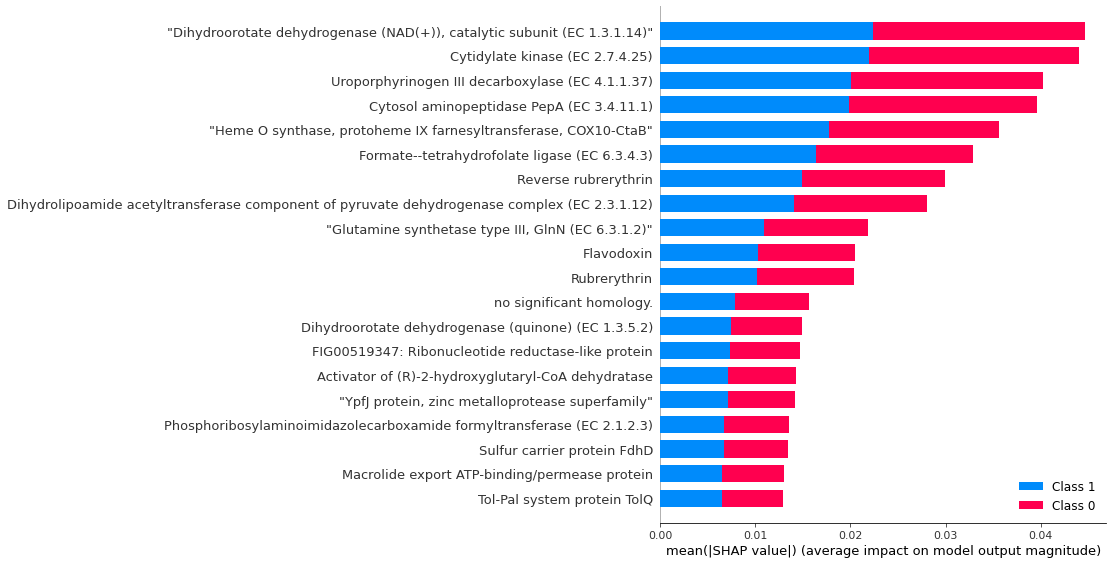

In [60]:
X_train_with_feat_names = X_train.copy()
X_train_with_feat_names.columns = [pgfams[pgfam] for pgfam in X_train_with_feat_names.columns]

shap_values = explainer.shap_values(X_train_with_feat_names)
shap.summary_plot(shap_values, X_train_with_feat_names, plot_type="bar")

In [28]:
class_features = feature_importance.get_top_features_per_class_in_multiple_runs(X_train, y_train, feature_importance.feature_importance, n_runs=100)

In [31]:
hps_mdi_df, nhps_mdi_df = feature_importance.create_top_feats_df(class_features, X_train, y_train, pgfams, top_feats=15)

In [32]:
hps_mdi_df.index = range(1, len(hps_mdi_df)+1)
hps_mdi_df

Feature  \
1   PGF_04139053   
2   PGF_01915472   
3   PGF_07629184   
4   PGF_07157721   
5   PGF_00022550   
6   PGF_01033770   
7   PGF_00006100   
8   PGF_07941512   
9   PGF_00405499   
10  PGF_06757295   
11  PGF_08199696   
12  PGF_03081665   
13  PGF_07854425   
14  PGF_01668012   
15  PGF_01147190   

                                                                                        Function  \
1                                               Uroporphyrinogen III decarboxylase (EC 4.1.1.37)   
2   Dihydrolipoamide acetyltransferase component of pyruvate dehydrogenase complex (EC 2.3.1.12)   
3                                                      Cytosol aminopeptidase PepA (EC 3.4.11.1)   
4                                "Heme O synthase, protoheme IX farnesyltransferase, COX10-CtaB"   
5                                    Molybdopterin synthase catalytic subunit MoaE (EC 2.8.1.12)   
6                                            Dihydroorotate dehydrogenase (quinone) (EC 1.3.5.2)   
7                                                                    tRNA-modifying protein YgfZ   
8                                  23S rRNA (uracil(1939)-C(5))-methyltransferase (EC 2.1.1.190)   
9                                               "YpfJ protein, zinc metalloprotease superfamily"   
10                                              Threonine dehydratase biosynthetic (EC 4.3.1.19)   
11                                                            Glutathione reductase (EC 1.8.1.7)   
12                     "Cell division integral membrane protein, YggT and half-length relatives"   
13                                          Superoxide dismutase [Cu-Zn] precursor (EC 1.15.1.1)   
14                                                                   Sulfur carrier protein FdhD   
15                                                Deoxyribodipyrimidine photolyase (EC 4.1.99.3)   

   Mean Importance (SD)  HPs  NHPs  P-Ratio  # Genera  
1         0.038 (0.012)  362    27     6.47       109  
2          0.035 (0.01)  385    48     3.93       120  
3          0.03 (0.009)  366    39     4.58       115  
4         0.022 (0.007)  312    14    10.41        89  
5         0.013 (0.005)  303    17     8.42        89  
6         0.011 (0.005)  333    35     4.63        99  
7         0.011 (0.006)  305    17     8.48        93  
8          0.01 (0.003)  324    37     4.27        89  
9         0.009 (0.003)  273    13     9.76        87  
10        0.008 (0.004)  323    34     4.62        95  
11        0.008 (0.002)  220    12     8.48        66  
12        0.007 (0.003)  352    56     3.09       109  
13        0.006 (0.001)  252    21     5.74        75  
14        0.006 (0.003)  300    26     5.56        98  
15        0.006 (0.003)  281    17     7.82        88

Save table

In [33]:
output_path = r'C:\Users\dinasv\Notebook\Shaked\latex\\'
hps_mdi_df.to_latex(output_path + 'top_hps.tex')

In [34]:
nhps_mdi_df

Feature  \
1   PGF_03029062   
2   PGF_01667671   
3   PGF_02930287   
4   PGF_08946513   
5   PGF_01469197   
6   PGF_01333294   
7   PGF_01284176   
8   PGF_00006245   
9   PGF_00033940   
10  PGF_10332317   
11  PGF_08126536   
12  PGF_00401757   
13  PGF_00016404   
14  PGF_00075770   
15  PGF_00003251   

                                                                     Function  \
1    "Dihydroorotate dehydrogenase (NAD(+)), catalytic subunit (EC 1.3.1.14)"   
2                                             Cytidylate kinase (EC 2.7.4.25)   
3                                                        Reverse rubrerythrin   
4                                                                  Flavodoxin   
5                                        "RNA methyltransferase, TrmA family"   
6                          Activator of (R)-2-hydroxyglutaryl-CoA dehydratase   
7                                                                Rubrerythrin   
8                               Formate--tetrahydrofolate ligase (EC 6.3.4.3)   
9      Phosphoribosylaminoimidazolecarboxamide formyltransferase (EC 2.1.2.3)   
10                                    Electron transport complex protein RnfB   
11                                                               Flavoprotein   
12                                                   no significant homology.   
13  "LSU ribosomal protein L32p @ LSU ribosomal protein L32p, zinc-dependent"   
14                         FIG00519347: Ribonucleotide reductase-like protein   
15                              Macrolide export ATP-binding/permease protein   

   Mean Importance (SD)  HPs  NHPs  P-Ratio  # Genera  
1          0.034 (0.01)   70   182     5.17        98  
2         0.031 (0.009)    7   125    31.57        60  
3          0.027 (0.01)   11   125    21.05        57  
4         0.021 (0.007)   67   170     5.04        94  
5         0.021 (0.009)   76   180     4.71       100  
6         0.019 (0.007)   25   128     9.95        77  
7         0.018 (0.009)   35   142     7.96        81  
8         0.016 (0.007)  138   201     2.91       122  
9         0.016 (0.006)    6   106    30.64        53  
10        0.014 (0.006)   18   123    13.08        62  
11        0.013 (0.006)   13   114    16.47        58  
12        0.013 (0.006)    8   106    23.83        44  
13        0.012 (0.005)   88   173     3.92       100  
14        0.012 (0.003)   51   135     5.24        76  
15         0.01 (0.002)   16    69     8.25        40

In [64]:
set(hps_mdi_df['Feature'][:15]).intersection(hps_mda_df['Feature'][:15])

{'PGF_01147190',
 'PGF_01915472',
 'PGF_04139053',
 'PGF_07157721',
 'PGF_08199696'}

In [65]:
old_features = ['PGF_07157721', 
                'PGF_00022550', 
                'PGF_00405499',
                'PGF_06594013',
                'PGF_06757295',
                'PGF_07941512',
                'PGF_00006461',
                'PGF_00037937',
                'PGF_03081665',
                'PGF_02905791',
                'PGF_08199696',
                'PGF_01147190',
                'PGF_07854425',
                'PGF_01761390',
                'PGF_09847065'
               ]

In [67]:
len(set(hps_mdi_df['Feature'][:15]).intersection(old_features))

9